## Install segment_anything package

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\reinhard\appdata\local\temp\pip-req-build-_0pjx3h8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36832 sha256=9e574b83c29432d9e8a2be8fd404b1096d4cfe0b1c08f18e416619062c315a2b
  Stored in directory: C:\Users\Reinhard\AppData\Local\Temp\pip-ephem-wheel-cache-zpfekcrf\wheels\29\82\ff\04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\Reinhard\AppData\Local\Temp\pip-req-build-_0pjx3h8'


In [5]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator #type:ignore
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure #type: ignore
from skimage.measure import label, regionprops, find_contours #type:ignore
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
from glob import glob
import random
import matplotlib.pyplot as plt

In [2]:
%%time
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = 'vit_h'
CHECKPOINT_PATH = 'C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge/sam_vit_h_4b8939.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


CPU times: total: 40 s
Wall time: 1min 26s


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [3]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
def draw_vertical_lines(image, n, line_color=(255, 0, 0), line_width=1, font_size=40):
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Load a font with the specified size
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)  # Common WSL font
    except IOError:
        font = ImageFont.load_default()  # Fallback if the font file is not found

    # Calculate spacing between lines
    step = width / n
    number_colors = [(0, 0, 255), (0, 255, 0), (255, 165, 0), (128, 0, 128), (0, 255, 255)]  # Example colors

    # Draw the vertical lines
    for i in range(1, n):  # Exclude the first and last edges
        x = int(i * step)
        draw.line([(x, 0), (x, height)], fill=line_color, width=line_width)

    # Add numbers in each region with different colors
    for i in range(n):
        num_x = int((i + 0.5) * step)  # Center in the region
        num_y = height // 2  # Vertically centered
        num_color = random.choice(number_colors)  # Choose a random color
        text = str(i + 1)

        # Get text bounding box to adjust positioning
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        draw.text((num_x - text_width // 2, num_y - text_height // 2), text, fill=num_color, font=font)

    return image


def merge_left_right(limg, rimg):
    
    # Ensure both images have the same width
    width = min(limg.width, rimg.width)
    _,height = limg.size
    limg = limg.crop((0, 0, width, height))
    _,height = rimg.size
    rimg = rimg.crop((0, 0, width, height))
    
    # limg = limg.resize((width, limg.height))
    # rimg = rimg.resize((width, rimg.height))
    
    # Create a new image with combined height
    stacked_img = Image.new("RGB", (width, limg.height + rimg.height))
    
    # Paste images on top of each other
    stacked_img.paste(rimg.rotate(180), (0, 0))
    stacked_img.paste(limg, (0, rimg.height))
    
    return stacked_img

def stack_images_vertically(images):
    
    # Ensure all images have the same width by cropping to the smallest width
    min_width = min(img.width for img in images)
    images = [img.crop((0, 0, min_width, img.height)) for img in images]
    
    # Calculate total height
    total_height = sum(img.height for img in images)
    
    # Create a new image with combined height
    stacked_img = Image.new("RGB", (min_width, total_height))
    
    # Paste images on top of each other
    y_offset = 0
    for img in images:
        stacked_img.paste(img, (0, y_offset))
        y_offset += img.height
    
    # Save the stacked image
    return stacked_img

def see_all_plants(fname, s=8, e=61):
    limgs = sorted(glob(f'data/train/{fname}/{fname}_L_*.png'))
    rimgs = sorted(glob(f'data/train/{fname}/{fname}_R_*.png'))
    
    lims = [Image.open(i) for i in limgs][s:e]
    rims = [Image.open(i) for i in rimgs][s:e]
    
    ims = []
    for l,r in zip(lims, rims):
        i = merge_left_right(l,r)
        ims.append(i)
    
    return stack_images_vertically(ims)

In [6]:
train = pd.read_csv('Train.csv')
train.head()


,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


(903, 280)


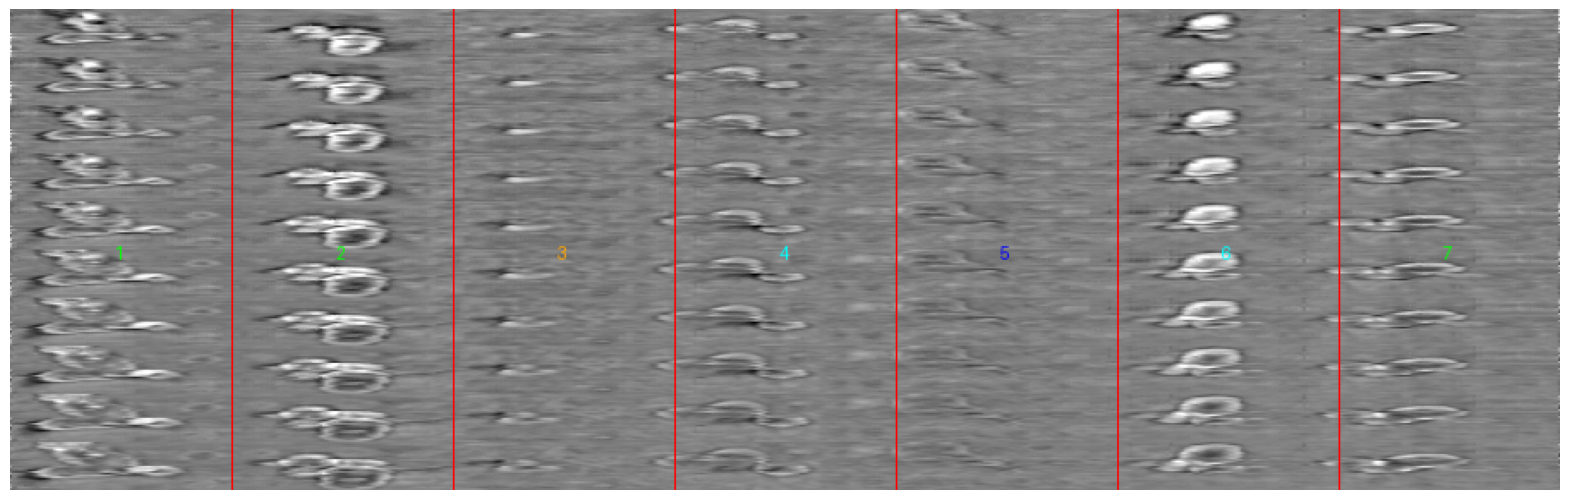

In [9]:
folders = train.FolderName.value_counts().index.values
folder = folders[0]
folder = 'Idiolerx47'
img = see_all_plants(folder, s=20, e=30)
img = draw_vertical_lines(img, n=7)
print(img.size)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
IMAGE_PATH = 'C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge/data/train/A2miww5mfx'
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

error: OpenCV(4.10.0) C:\b\abs_34oziifb73\croot\opencv-suite_1738308891325\work\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
len(result)

In [12]:
import pandas as pd

train = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')
dg = train.groupby('Genotype')['RootVolume'].mean().reset_index()

dg = dg.groupby('Genotype')['RootVolume'].mean().reset_index()

test = test.merge(dg, on='Genotype', how='left')

test[['ID','RootVolume']].to_csv('Genotype_mean.csv', index=False)

In [13]:
geno = pd.read_csv('Genotype_mean.csv')
geno.head()

,ID,RootVolume
0,ID_208667_Hnkl8q,2.890556
1,ID_285249_Jnjvav,2.192527
2,ID_697947_Yec6bd,2.030758
3,ID_534638_X3j91f,2.192527
4,ID_929298_Xvymuz,2.073611


In [ ]:
import pandas as pd
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

#sub = pd.read_csv('sub.csv') # private lb 1.32
test = test.merge(sub,on='ID',how='left')
test['test_gmean'] = test.groupby('Genotype')['RootVolume'].transform('mean')
dg = train.groupby('Genotype')['RootVolume'].mean().reset_index().rename(columns={'RootVolume':'train_gmean'})
test = test.merge(dg, on='Genotype', how='left')
test['RootVolume'] = test['RootVolume']/test['test_gmean']*test['train_gmean']

test[['ID','RootVolume']].to_csv('sub_adjust.csv', index=False) # private lb 1.18

FileNotFoundError: [Errno 2] No such file or directory: 'sub.csv'